## Using Concentriq® Embeddings for unsupervised clustering

In this demo/walkthrough we'll utilize the simple Python client developed specifically for Concentriq® Embeddings and secure our access to Concentriq® for Research and Concentriq® Embeddings.

In [1]:
import yaml

from utils.client import ClientWrapper as Client
from utils import utils

with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

# To use CPU instead of GPU, set `device` parameter to `"cpu"`
ce_api_client = Client(**creds, device='cpu')
ce_api_client

## Embedding the IMPRESS dataset

For this demo we’ve elected to use the [IMPRESS dataset](https://arxiv.org/html/2306.01546v2), a publicly available dataset containing 126 breast H&E and 126 IHC WSIs from 62 female patients with HER2-positive breast cancer and 64 female patients diagnosed with triple-negative breast cancer. All the slides are scanned using a Hamamatsu scanner with 20x magnification. These WSIs are stored in a repository (ID: 1918) in Concentriq® for Research. 

To get started, we'll submit a job for our entire dataset and request our embeddings at a scale of 1 µm/pixel (mpp).

In [2]:
repo_ids = [1918] # The IMPRESS Dataset
ticket_id = ce_api_client.embed_repos(ids=repo_ids, model="1aurent/swin_tiny_patch4_window7_224.CTransPath", mpp=1)

# Alternatively, load a previously generated embedding
# ticket_id = '96c26fb0-5491-4f4b-ad5e-3d7238856c0e'
# print(ticket_id)

## Retrieving and Understanding the Embedding Results

Now the embedding job is running and Concentriq® Embeddings is running inference with our selected foundation model. With `get_embeddings`, we can check for completed results, and when complete they’ll get pulled down to a local cache. If the cache is already stored locally, `get_embeddings` will load out the results on demand from disk.


In [3]:
embeddings = ce_api_client.get_embeddings(ticket_id)
print(f"{ticket_id}: {len(embeddings['images'])} images")
print(f"{embeddings['images'][0]['model']} - {embeddings['images'][0]['patch_size']}")

96c26fb0-5491-4f4b-ad5e-3d7238856c0e: 252 images
1aurent/swin_tiny_patch4_window7_224.CTransPath - 224


The retrieved embedding file includes metadata about the embeddings job we submitted and each WSI processed. The embeddings themselves are loaded as a dictionary of tensors with keys in "Y_X" format indicating the grid index of the embedded patch.

Here we print the information corresponding to each WSI. This includes the parameters supplied along with implicit attributes of the data, like the foundation model’s native patch size, as well as all of the other spatial information associated with each WSI’s tile embeddings.


In [4]:
for key, value in embeddings['images'][0].items():
    if key not in ['embedding', 'embeddings_url']:
        print(f"{key}: {value}")

image_id: 6682
repository_id: 1918
status: finished
model: 1aurent/swin_tiny_patch4_window7_224.CTransPath
patch_size: 224
grid_rows: 89
grid_cols: 71
pad_height: 56
pad_width: 113
mpp: 1.0
local_embedding_path: ./data/96c26fb0-5491-4f4b-ad5e-3d7238856c0e_6682.safetensors


 At this point, this dataset has been processed into embeddings: the dataset is lightweight and ready for downstream analysis, be that classification, segmentation, regression, etc. For this example, we will show how to cluster similar embedding vectors and visualize the underlying tiles. 


In [5]:
embeddings['images'][0]['embedding']['0_0'].shape

torch.Size([768])

## Fetch thumbnails for visualization
The embeddings api also contains am endpoint for fetching lightweight thumbnail images that allows us to visualize the image tiles associated with each embedding – let’s fetch the thumbnail images and tile those as well.

In [6]:
thumbnail_ticket_id = ce_api_client.thumbnail_repos(ids=repo_ids)
# print(thumbnail_ticket_id)

In [7]:
# Using a previously generated thumbnail ticket
# thumbnail_ticket_id = "172f6340-d678-4e2b-bf9f-f982e5d88c21"

In [8]:
thumbnails = ce_api_client.get_thumbnails(thumbnail_ticket_id, load_thumbnails=True)

In [9]:
# link the thumbnails to the embeddings
for emb in embeddings['images']:
    thumbnail_dict = [thumb for thumb in thumbnails['thumbnails'] if thumb['image_id'] == emb['image_id']][0]
    emb.update(thumbnail_dict)

In [10]:
emb = embeddings['images'][0]
tiles = utils.tile_thumbnail(emb)
emb['tiles'] = tiles
len(tiles)

6319

## Visualization and Clustering of Tile Embeddings
Next let’s import some things to allow us to cluster and visualize

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

np.random.seed(42)

## Visualizing Embedded Space

Great! Now let's pull out a sample over the entire dataset and cluster the embeddings to explore the approximate structure of the feature space represented by the embeddings.


In [12]:
images = [e for e in embeddings['images']]
all_X = []
res_df = []
for image in images:
    skeys, locdict = utils.parse(image['embedding'])
    tiles = utils.tile_thumbnail(image)
    image['tiles'] = tiles
    sample_keys = np.random.choice(skeys, size=min(1000, len(skeys)), replace=False)
    
    image['sample_keys'] = sample_keys
    sample_X = utils.stack_embedding(image['embedding'], image['sample_keys'])
    df = pd.DataFrame({"sample_key": image['sample_keys']})
    df["image_id"] = image["image_id"]
    all_X.append(sample_X)
    res_df.append(df)
    
sample_df = pd.concat(res_df)
sample_df['index'] = np.arange(len(sample_df))
all_X = np.concatenate(all_X, axis=0)

We can zoom in and visualize sample tiles from some of the clusters to confirm that the model is distinguishing relevant tissue types and structures. We’ll again use the low resolution thumbnails returned by the API to generate downsampled versions of the tiles. While these images are lower resolution (32x32 at 7 mpp) than the patches seen by the foundation model (224x224 at the requested 1 mpp), it is easy to see that the model separates the dataset into coherent tissue & stain combinations.

In [13]:
n_clusters = 20
cluster_membership = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit_transform(all_X)

3


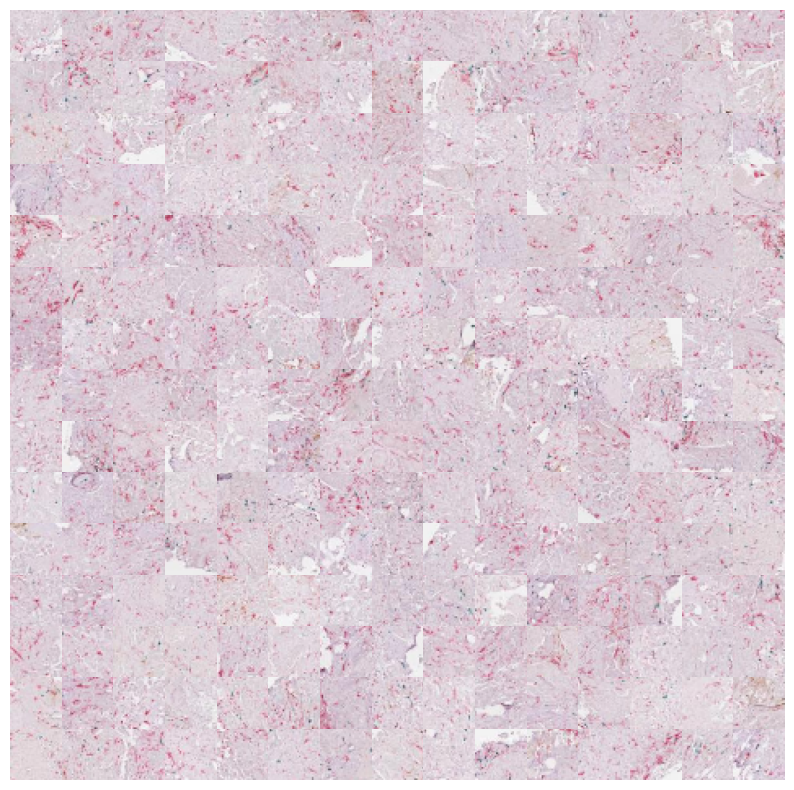

4


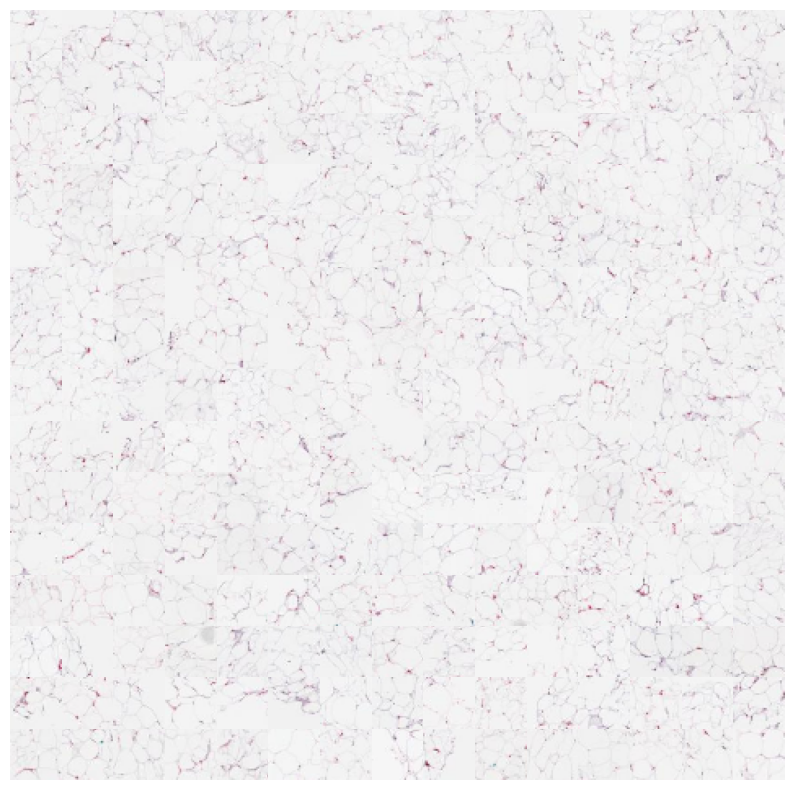

5


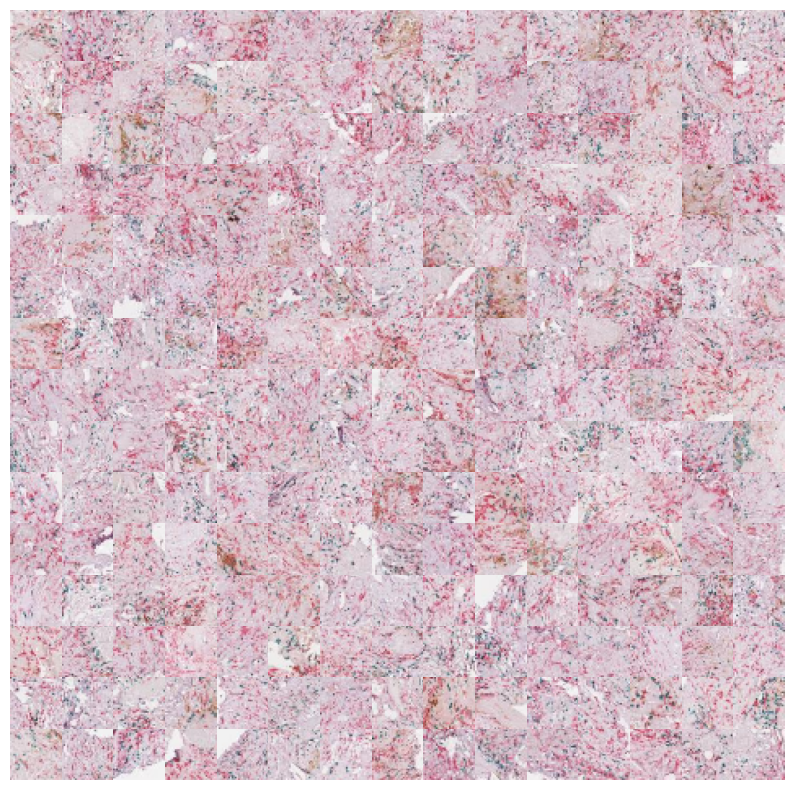

7


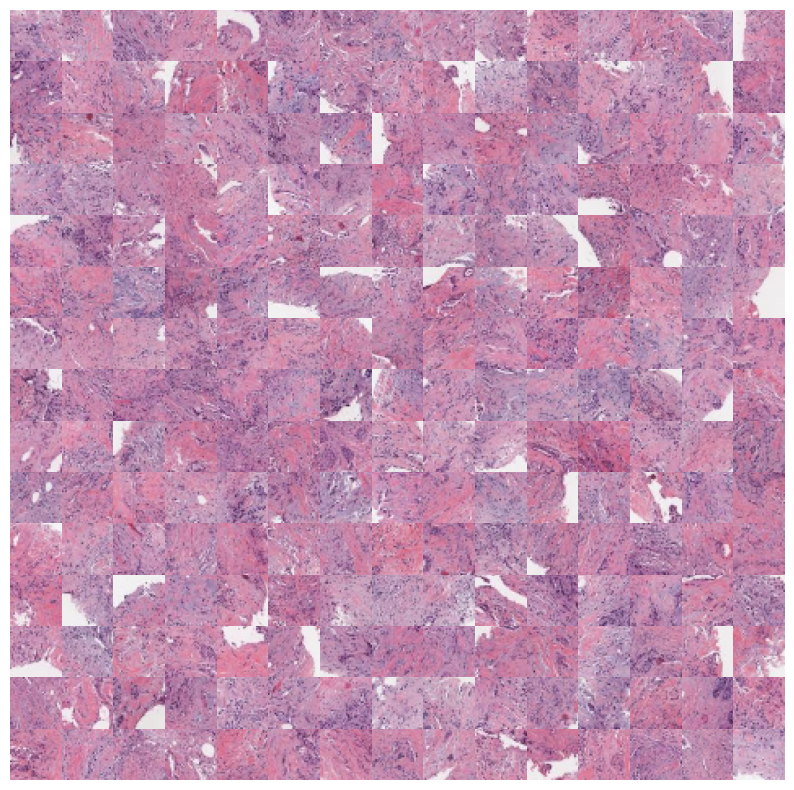

13


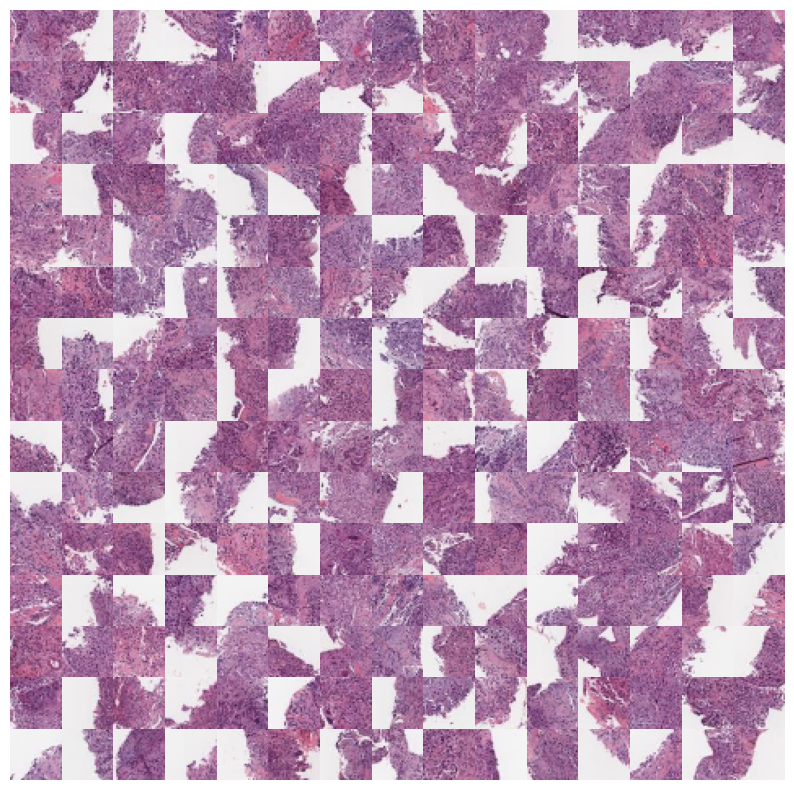

14


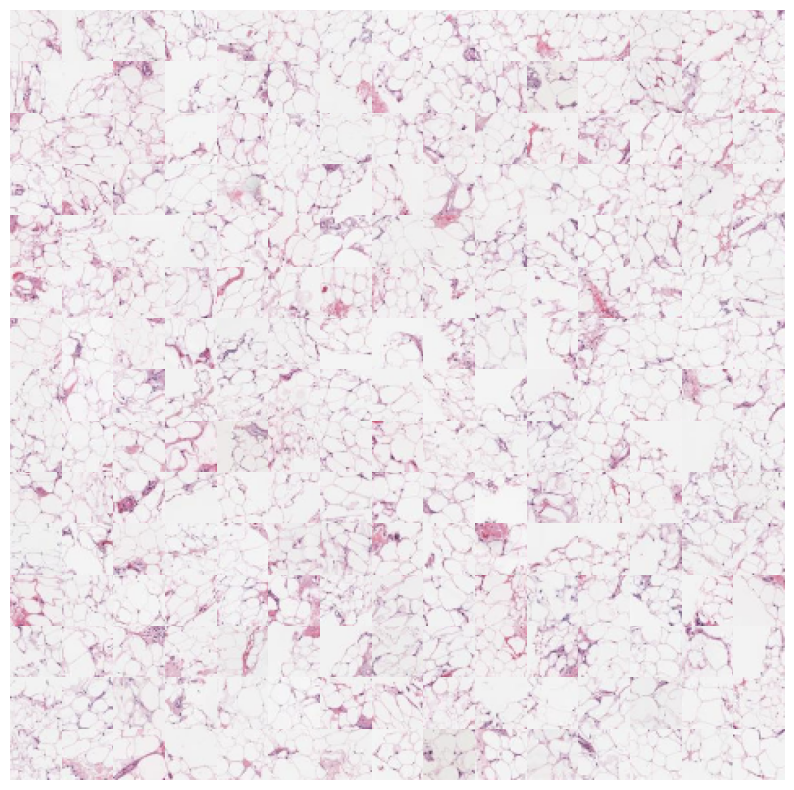

18


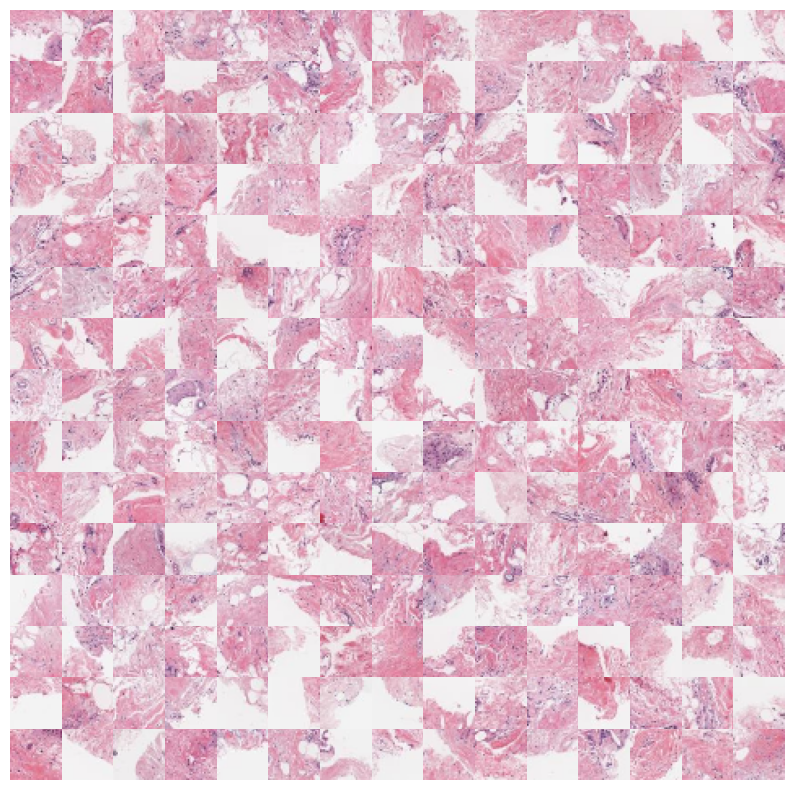

In [14]:
n_rows = 15
for cluster in [3,4,5,7,13,14,18]:
    top_n = cluster_membership[:,cluster].argsort()[:n_rows*n_rows]
    cluster_df = sample_df.iloc[top_n]
    print(cluster)
    fig, axx = plt.subplots(n_rows,n_rows,figsize=(10, 10))
    for i in range(n_rows*n_rows):
        ax = axx[i//n_rows, i%n_rows]
        ax.axis('off')
        # get the thumbnail for the key
        key = cluster_df['sample_key'].values[i]
        image_id = cluster_df['image_id'].values[i]
        emb = [e for e in embeddings['images'] if e['image_id'] == image_id][0]
        tile = emb['tiles'][key]
        ax.imshow(tile)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

That’s all there is to it! That’s how easy it is to cluster and explore your data with foundation models using Concentriq® Embeddings. Hello computational pathology world.

## Foundation models could be at your fingertips

Concentriq® Embeddings removes the barriers between researchers and valuable insights. Concentriq® Embeddings makes grabbing features with a foundation model as easy as grabbing a cup of coffee. Researchers can now bypass the cumbersome steps of downloading massive WSI files, wrestling with poorly maintained software, and keeping track of thousands if not millions of cropped image files that might be outdated as soon as they hit the hard drive. No heavy compute, no GPUs, no piles of harddrives. You get straight to building your models. With Concentriq® Embeddings, transition seamlessly from slides to extracted features, ready for downstream task development. The barrier between your data and your models is no more.